In [1]:
import numpy as np
import pandas as pd

import re

In [2]:
df = pd.read_csv('../test/batches/batch_000.csv')

In [3]:
bad_df = df[~df['flags'].isna()]

In [4]:
bad_df

,frequency_index,frequency,kurtosis,snr,width,flags,source file
316,7119360,3131.572151,0.730411,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...
409,12667392,3116.071129,1.801510,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...
410,12667904,3116.069698,1.661730,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...
432,14053888,3112.197304,0.444417,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...
571,30610432,3065.938854,9.711759,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...
572,30610944,3065.937424,7.597900,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...
573,30611968,3065.934563,1.014968,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...
574,30612480,3065.933132,2.264908,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...
579,30622208,3065.905952,1.542258,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...
580,30622720,3065.904522,0.797327,NaN,NaN,fit error OptimizeWarning('Covariance of the p...,/home/andres/breakthrough-listen/data/blc40_gu...


In [5]:
import hdf5plugin
import h5py

f = h5py.File('/home/andres/breakthrough-listen/data/blc40_guppi_59358_40991_HIP3740_0031.rawspec.0000.h5')
data: h5py.Dataset = f['data'] #type: ignore

In [6]:
bad_hit = bad_df.iloc[0]
l_idx = bad_hit.frequency_index

In [7]:
bad_data = data[:, 0, l_idx : l_idx+1024]

foff: float = data.attrs['foff'] #type: ignore
fch1: float = data.attrs['fch1'] #type: ignore
freq_array = np.linspace(
    fch1 + foff * l_idx,
    fch1 + foff * (l_idx + 1024),
    num=bad_data.shape[1]
) #type: ignore

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
import re
m = re.search(
    r"fit error OptimizeWarning\('Covariance of the parameters could not be estimated', 'time slice index: (\d+)'\)",
    bad_hit['flags']
)
if m:
    bad_slice_idx = int(m.group(1))
    print(bad_slice_idx)
else:
    raise ValueError(f'Could not get time slice {bad_hit['flags']}')
y_vals = bad_data[bad_slice_idx, :]
# y_vals[y_vals.argmax()] = (y_vals[y_vals.argmax() - 1] + y_vals[y_vals.argmax() + 1])/2

14


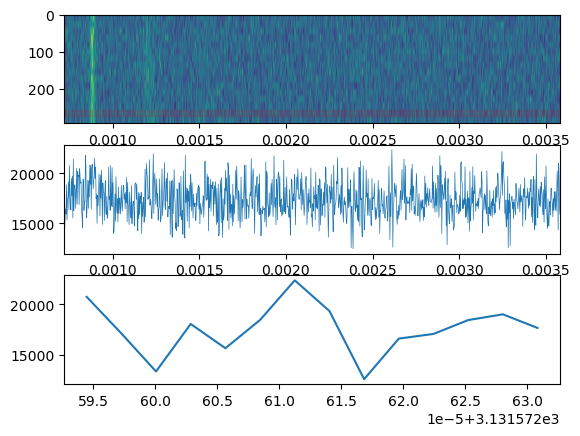

In [46]:
fig = plt.figure()

ax = fig.add_subplot(311)
ax.imshow(
    bad_data,
    extent=(
        freq_array[0], freq_array[-1],
        0, data.attrs['tsamp'] * bad_data.shape[0]
    ),
    aspect='auto',
    # norm='log'
)
ax.axhspan(
    bad_slice_idx * data.attrs['tsamp'],
    (bad_slice_idx + 1) * data.attrs['tsamp'],
    color = 'red', alpha = 0.1)
ax.invert_xaxis()
ax.invert_yaxis()

slice_ax = fig.add_subplot(312, sharex=ax)
slice_ax.plot(freq_array, y_vals, lw = 0.5)

max_arg = y_vals.argmax()
width = 7
zoom_ax = fig.add_subplot(313)
zoom_ax.plot(freq_array[max_arg-width : max_arg+width], y_vals[max_arg-width : max_arg+width])

plt.show()

In [48]:
import scipy.optimize
import warnings
warnings.filterwarnings('always')

def signal_model(x, mean, stdev, amp, noise):
    exponent = -0.5 * ((x - mean)/stdev)**2
    return noise + amp * np.exp(exponent)

params, covt = scipy.optimize.curve_fit(
    signal_model, 
    freq_array, 
    y_vals, 
    p0=[
        freq_array[np.argmax(y_vals)], 
        np.abs(f['data'].attrs['foff']), # type: ignore
        np.max(y_vals) - np.median(y_vals),
        np.median(y_vals)
    ],
    # # slow, screws up scale for some signals
    # bounds=np.array([
    #     (freq_array[-1], freq_array[0]),
    #     (0, np.inf),
    #     (0, np.inf),
    #     (0, np.inf)
    # ]).T,
    # max_nfev=10_000
)

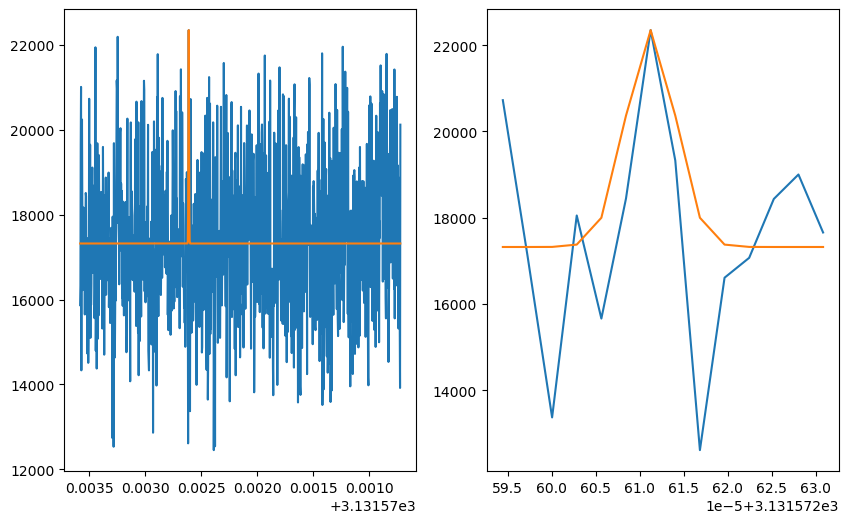

In [49]:
fig = plt.figure(figsize=(10, 6))

slice_ax = fig.add_subplot(121)
slice_ax.plot(freq_array, y_vals)
slice_ax.plot(freq_array, signal_model(freq_array, *params))
slice_ax.invert_xaxis()

max_arg = y_vals.argmax()
width = 7
zoom_ax = fig.add_subplot(122)
zoom_ax.plot(freq_array[max_arg-width : max_arg+width], y_vals[max_arg-width : max_arg+width])
zoom_ax.plot(freq_array[max_arg-width : max_arg+width], signal_model(freq_array, *params)[max_arg-width : max_arg+width])

plt.show()

In [39]:
spike_idx = np.argmax(y_vals)
width = 5_000_000

view_vals = np.mean(f['data'][:, 0, l_idx+spike_idx-width : l_idx+spike_idx+width], axis = 0)

In [ ]:
plt.xlim(0, 2*(l_idx+spike_idx))
plt.plot(f['data'][bad_slice_idx, 0, :])
plt.axvline((l_idx+spike_idx), alpha=0.1)
plt.yscale('log')
plt.show()

In [23]:
(l_idx + spike_idx) % (1048576//2)

np.int64(0)